In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import math as mt
import os
import pickle
import mlflow
import mlflow.keras

In [2]:
# print("numpy=="+np.__version__)
# print("tensorflow=="+tf.__version__)
# print("pandas=="+pd.__version__)
# print("mlflow=="+mlflow.__version__)


In [3]:
bs=10
epochs=150

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [5]:



mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("graph-neural-network-trial-batch-norm")

<Experiment: artifact_location='./mlruns/4', experiment_id='4', lifecycle_stage='active', name='graph-neural-network-trial-batch-norm', tags={}>

In [6]:
mlflow.tensorflow.autolog()

In [7]:
# def adjm(h,w,near):
#   am=[[0 for i in range(w*h)] for j in range(h*w)]
#   img=[[0 for i in range(w)] for j in range(h)]
  
#   dr=[[1,0],[0,1],[1,1],[-1,-1],[-1,0],[0,-1],[-1,1],[1,-1]]

#   for i,v in enumerate(img):
#     for j,v2 in enumerate(img[i]):
#       timg=[[0 for i in range(w)] for j in range(h)]
#       for k in range(0,near+1):
#         for d in dr:
#           posy=i+d[0]*k
#           posx=j+d[1]*k
#           if posy>=0 and posy<h and posx>=0 and posx<w:
#             timg[posy][posx]=1
#             am[i*w+j][posy*w+posx]=1
#         print(timg)  

#   return am

# val=adjm(4,5,1)

In [8]:
with open('data/train/x_train.pkl','rb') as f:
        x1=pickle.load(f)
with open('data/train/y_train.pkl','rb') as f:
        y1=pickle.load( f)
with open('data/valid/x_valid.pkl','rb') as f:
        x2=pickle.load(f)
with open('data/valid/y_valid.pkl','rb') as f:
        y2=pickle.load( f)
with open('data/test/x_test.pkl','rb') as f:
        x3=pickle.load(f)
with open('data/test/y_test.pkl','rb') as f:
        y3=pickle.load( f)

In [9]:
# with open('data/test/x_test.pkl','rb') as f:
#         x3=pickle.load(f)
# with open('data/test/y_test.pkl','rb') as f:
#         y3=pickle.load( f)

In [10]:
x1.shape

(31640, 9, 12)

In [11]:
# print(max(y1[0]))

In [12]:
class GCN(tf.keras.layers.Layer):
    def __init__(self,inp_shape=9*12,out_shape=9*12,h=9, w=12,near=3):
        super(GCN, self).__init__()
        self.am=[[0 for i in range(w*h)] for j in range(h*w)]
        self.img=[[0 for i in range(w)] for j in range(h)]
  
        self.dr=[[1,0],[0,1],[1,1],[-1,-1],[-1,0],[0,-1],[-1,1],[1,-1]]

        for i,v in enumerate(self.img):
           for j,v2 in enumerate(self.img[i]):
        # timg=[[0 for i in range(w)] for j in range(h)]
              for k in range(0,near+1):
                for d in self.dr:
                  posy=i+d[0]*k
                  posx=j+d[1]*k
                  if posy>=0 and posy<h and posx>=0 and posx<w:
            # timg[posy][posx]=1
                    self.am[i*w+j][posy*w+posx]=1
        # print(timg) 
        self.am=np.array(self.am) 
        self.D = np.diag(np.sum(self.am, axis=0)) 
        self.Dinv=np.linalg.inv(self.D)
        self.am=tf.Variable(self.am,trainable=True,dtype=tf.float32)
        self.Dinv=tf.Variable(self.Dinv,trainable=True,dtype=tf.float32)
        # self.norm=tf.matmul(self.Dinv*self.am)
        self.w = self.add_weight(
            shape=(inp_shape, out_shape), initializer="random_normal", trainable=True,dtype=tf.float32
        )
        # self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=True)

    def call(self, inputs):
        inputs=tf.cast(inputs,dtype=tf.float32)
    
        # print("inpshape",tf.transpose(inputs,perm=[1,0]).shape)
        # print(self.Dinv.shape)
        # print(self.am.shape)
        # print(self.w.shape)
        first_half=tf.matmul(inputs,tf.matmul(self.Dinv,self.am))
    
        return tf.matmul(first_half, self.w) 

In [13]:
def build_model(near=3,lay=2,bs=bs,n_out=7):
    inputs = tf.keras.Input( shape=(9,12),
    batch_size=bs)
    mlflow.log_param("layers", lay)
    mlflow.log_param("nearest", near)
    mlflow.set_tag("layer", "changed")
    print(inputs.shape)
    x=tf.reshape(inputs,[bs,inputs.shape[1]*inputs.shape[2]],name="initial reshape")
    for i in range(lay):
        x=GCN(near=near)(x)
        x=tf.keras.layers.Activation('relu',name="graph_layer"+str(i+1))(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Dense(units=32,activation="relu",name="dense1")(x)
    output=tf.keras.layers.Dense(n_out,activation="softmax",name="out_layer")(x)
    model = tf.keras.Model(inputs=inputs, outputs=output, name="graph_neuralnetwork")

    model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=["accuracy"],
)
    return model

In [14]:
model=build_model(0)

(10, 9, 12)


In [15]:
!pip install shap

You should consider upgrading via the 'C:\Users\Acer\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [16]:
import shap
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
x1

array([[[0.5752505 , 0.66443235, 0.7418544 , ..., 0.73208207,
         0.72718614, 0.6115528 ],
        [0.7095544 , 0.7614971 , 0.82323956, ..., 0.7468288 ,
         0.6086559 , 0.57828057],
        [0.65374273, 0.75664425, 0.78604746, ..., 0.8213541 ,
         0.73903996, 0.55480814],
        ...,
        [0.73330903, 0.8009314 , 0.5726006 , ..., 0.61182714,
         0.65005016, 0.59027547],
        [0.6853372 , 0.648102  , 0.38743198, ..., 0.6471534 ,
         0.6059982 , 0.4590056 ],
        [0.6011062 , 0.6863681 , 0.7520305 , ..., 0.6472004 ,
         0.59428555, 0.5443106 ]],

       [[0.67520815, 0.6957916 , 0.630137  , ..., 0.60860497,
         0.7242462 , 0.7075905 ],
        [0.7203341 , 0.6527196 , 0.61450446, ..., 0.52731395,
         0.5978762 , 0.7086175 ],
        [0.66256255, 0.595928  , 0.54497313, ..., 0.22062813,
         0.24317151, 0.33333334],
        ...,
        [0.6823502 , 0.43245998, 0.5441813 , ..., 0.7343243 ,
         0.59125155, 0.4315192 ],
        [0.7

In [18]:
len(y3)

750

In [19]:
# Name each one of the classes
class_names = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC']
# Save an example for each category in a dict
images_dict = dict()
for i, l in enumerate(y1):
  # print(l)
  index = l.tolist().index(1)
  if len(images_dict)==7:
    break
  if index not in images_dict.keys():
    images_dict[index] = x1[i].reshape((9, 12))


In [20]:
images_dict[0][0][0]

0.5752505

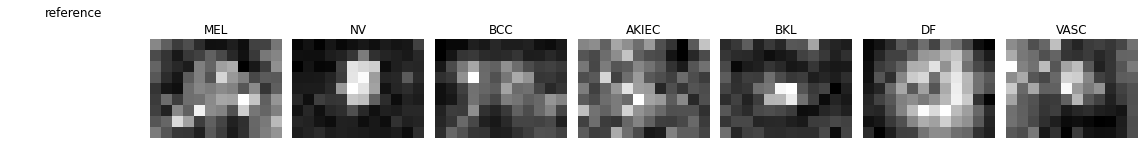

In [21]:
# Function to plot images
def plot_categories(images):
  fig, axes = plt.subplots(1, 8, figsize=(16, 15))
  axes = axes.flatten()
  
  # Plot an empty canvas
  ax = axes[0]
  dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
  ax.set_title("reference")
  ax.set_axis_off()
  ax.imshow(dummy_array, interpolation='nearest')

  # Plot an image for every category
  for k,v in images.items():
    ax = axes[k+1]
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"{class_names[k]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()


# Use the function to plot
plot_categories(images_dict)

In [22]:
x1.shape[0]

31640

In [23]:
# Take a random sample of 5000 training images
background = x1[np.random.choice(x1.shape[0], 5000, replace=False)]
len(background[0][0])

12

In [56]:


# Use DeepExplainer to explain predictions of the model
e = shap.Explainer(model, background)

# Compute shap values
# shap_values = e.shap_values(x_test[1:5])

In [25]:
x3demo = []
for i in range(len(x3)):
    supermain = []
    for j in range(len(x3[i])):
        main = []
        for k in range(len(x3[i][j])):
            main.append([x3[i][j][k]])
        supermain.append(main)
    x3demo.append(supermain)

In [54]:
len(x3demo)

750

In [27]:
x3[0][0][0]

0.37239522

In [28]:
# Save an example of each class from the test set
x_test_dict = dict()
for i, l in enumerate(y3):
  # print(l)
  index = l.tolist().index(1)
  if len(x_test_dict)==7:
    break
  if index not in x_test_dict.keys():
    x_test_dict[index] = x3[i]
print(x_test_dict)
# Convert to list preserving order of classes
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]

# Convert to tensor
x_test_each_class = np.asarray(x_test_each_class)

# Print shape of tensor
print(f"x_test_each_class tensor has shape: {x_test_each_class.shape}")

{3: array([[0.37239522, 0.42139798, 0.5164597 , 0.6105414 , 0.54194695,
        0.56743026, 0.6869914 , 0.5850777 , 0.53608274, 0.4282892 ,
        0.5645099 , 0.5654938 ],
       [0.5400183 , 0.52336264, 0.5704055 , 0.48123148, 0.6419516 ,
        0.47927937, 0.5831609 , 0.57336503, 0.6468672 , 0.5880725 ,
        0.55867714, 0.46264327],
       [0.57730454, 0.56456876, 0.6753101 , 0.63317496, 0.5557607 ,
        0.48618624, 0.6155471 , 0.72726846, 0.6077152 , 0.5048215 ,
        0.57048386, 0.5567681 ],
       [0.5469723 , 0.6253744 , 0.6577175 , 0.65772146, 0.55090785,
        0.5509118 , 0.6528333 , 0.34414443, 0.59992236, 0.4725293 ,
        0.60679007, 0.5548552 ],
       [0.5773986 , 0.6881399 , 0.62542534, 0.60190976, 0.4098382 ,
        0.61465734, 0.5607625 , 0.56370634, 0.6479883 , 0.6264327 ,
        0.6636758 , 0.5872415 ],
       [0.5225669 , 0.51375103, 0.60391283, 0.67447513, 0.58824104,
        0.38342977, 0.52553034, 0.56375337, 0.67645466, 0.65293914,
        0.59512

In [29]:
x_test_dict.keys()

dict_keys([3, 2, 1, 0, 4, 6, 5])

In [57]:
x_test_each_class

array([[[0.509592  , 0.6056337 , 0.60367763, 0.59584177, 0.6634641 ,
         0.6997272 , 0.6752317 , 0.65073615, 0.68013936, 0.6458441 ,
         0.62428856, 0.5811735 ],
        [0.5586379 , 0.6203804 , 0.63998383, 0.6174483 , 0.59001285,
         0.6027565 , 0.6399995 , 0.67038274, 0.67920643, 0.63805133,
         0.66353464, 0.6194396 ],
        [0.58906424, 0.58808815, 0.45677516, 0.42933974, 0.51068175,
         0.5910438 , 0.48423022, 0.5616523 , 0.61653495, 0.67239755,
         0.6724015 , 0.62830645],
        [0.5900912 , 0.57735544, 0.4911214 , 0.462706  , 0.5411081 ,
         0.46761373, 0.44115826, 0.40294307, 0.4705654 , 0.5960064 ,
         0.6616688 , 0.6528529 ],
        [0.62737745, 0.63816106, 0.52938753, 0.41179422, 0.2726414 ,
         0.36966303, 0.38632658, 0.3481114 , 0.38143453, 0.38927826,
         0.6401563 , 0.64996004],
        [0.6195846 , 0.6284084 , 0.40301755, 0.20016621, 0.1325517 ,
         0.11687599, 0.24035703, 0.24722078, 0.17078649, 0.22958903,
  

In [41]:
x3.shape

(750, 9, 12)

In [39]:
len(x3[0][0])

12

In [38]:
750*9*12

81000

In [47]:
# Compute predictions
predictions = model.predict(x3[:10])

1/1 [==============================] - 0s 184ms/step


In [ ]:
x_test_dict)

In [48]:


# Apply argmax to get predicted class
np.argmax(predictions, axis=1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [51]:
# Compute shap values using DeepExplainer instance
shap_values = e.shap_values(x_test_each_class)

AttributeError: module 'warnings' has no attribute 'DeprecationWarning'

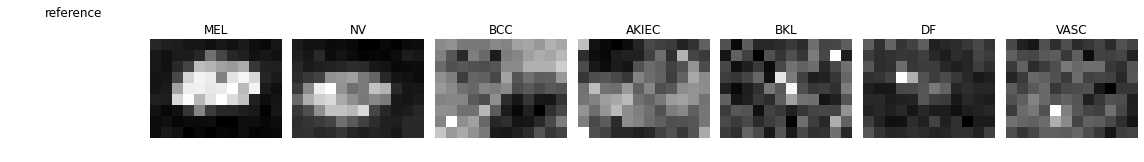

NameError: name 'shap_values' is not defined

In [ ]:
# Plot reference column
plot_categories(images_dict)

# Print an empty line to separate the two plots
print()

# Plot shap values
shap.image_plot(shap_values, -x_test_each_class)

In [ ]:
# Save the probability of belonging to each class for the fifth element of the set
coat_probs = predictions[4]

# Order the probabilities in ascending order
coat_args = np.argsort(coat_probs)

# Reverse the list and get the top 3 probabilities
top_coat_args = coat_args[::-1][:3]

# Print (ordered) top 3 classes
for i in list(top_coat_args):
  print(class_names[i])

NameError: name 'predictions' is not defined

In [ ]:
model.summary()

Model: "graph_neuralnetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(10, 9, 12)]             0         
                                                                 
 tf.reshape (TFOpLambda)     (10, 108)                 0         
                                                                 
 gcn (GCN)                   (10, 108)                 34992     
                                                                 
 graph_layer1 (Activation)   (10, 108)                 0         
                                                                 
 gcn_1 (GCN)                 (10, 108)                 34992     
                                                                 
 graph_layer2 (Activation)   (10, 108)                 0         
                                                                 
 batch_normalization (BatchN  (10, 108)        

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)

In [ ]:
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="mode/base_model",
#                                                  save_weights_only=True,
#                                                  verbose=1)

In [ ]:
# with mlflow.start_run(nested=true):
history = model.fit(x1,y1, batch_size=bs, epochs=epochs, callbacks=[callback],validation_data=(x2,y2),verbose=2)


Epoch 1/150
42/42 - 4s - loss: 2.1302 - accuracy: 0.1786 - val_loss: 22.5259 - val_accuracy: 0.1429 - 4s/epoch - 91ms/step
Epoch 2/150
42/42 - 0s - loss: 1.9370 - accuracy: 0.2048 - val_loss: 9.5422 - val_accuracy: 0.1429 - 281ms/epoch - 7ms/step
Epoch 3/150
42/42 - 0s - loss: 1.8921 - accuracy: 0.1929 - val_loss: 2.1150 - val_accuracy: 0.1857 - 278ms/epoch - 7ms/step
Epoch 4/150
42/42 - 0s - loss: 1.8706 - accuracy: 0.2310 - val_loss: 45.8393 - val_accuracy: 0.1429 - 311ms/epoch - 7ms/step
Epoch 5/150
42/42 - 0s - loss: 1.7696 - accuracy: 0.2310 - val_loss: 1.9678 - val_accuracy: 0.2286 - 274ms/epoch - 7ms/step
Epoch 6/150
42/42 - 0s - loss: 1.7380 - accuracy: 0.2667 - val_loss: 3.0304 - val_accuracy: 0.1643 - 241ms/epoch - 6ms/step
Epoch 7/150
42/42 - 0s - loss: 1.7302 - accuracy: 0.2786 - val_loss: 2.9058 - val_accuracy: 0.2429 - 233ms/epoch - 6ms/step
Epoch 8/150
42/42 - 0s - loss: 1.7788 - accuracy: 0.2738 - val_loss: 28.0583 - val_accuracy: 0.1429 - 246ms/epoch - 6ms/step
Epoch 9

2022/06/22 16:00:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Run with id=04a6b8d55e974438b2f8efed5a570fe7 not found


AssertionError: <class 'keras.callbacks.History'> is not currently a supported model type!

In [ ]:
type(model)

keras.engine.functional.Functional